In [1]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2

zipfile = bz2.BZ2File("./RML2016.10a.tar.bz2") # open the file
data = zipfile.read() # get the decompressed data

In [2]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [3]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./RadioML_data') # specify which folder to extract to
my_tar.close()

In [4]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("./RadioML_data/RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [5]:
# Import all the things we need ---
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten,LayerNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

In [6]:
# Partition the data
#  into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
#len(train_idx)

In [7]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [8]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [9]:
#Number of dimensions after PCA = n_components
# Reference: https://github.com/dl4amc/source
pca = PCA(n_components= 40)

In [10]:
# PCA
X_train = X_train.transpose((1, 0, 2))
X_train = np.append(X_train[0], X_train[1], axis=1)
pca_apply = pca.fit(X_train)
print('Shape of X_train before aaplying PCA', np.shape(X_train))
X_train = pca_apply.transform(X_train)
print('Shape of X_train after applying PCA', np.shape(X_train))
#print(len(X_train[1]))
X_test = X_test.transpose((1, 0, 2))
X_test = np.append(X_test[0], X_test[1], axis=1)
X_test = pca_apply.transform(X_test)
X_train = np.stack((X_train[:, :len(X_train[0])//2], X_train[:,len(X_train[0])//2:]), axis=1)
X_test = np.stack((X_test[:, :len(X_test[0])//2], X_test[:, len(X_test[0])//2:]), axis=1)
print('Final shape of X_train', np.shape(X_train))
print('Final shape of X_test', np.shape(X_test))

Shape of X_train before aaplying PCA (110000, 256)
Shape of X_train after applying PCA (110000, 40)
Final shape of X_train (110000, 2, 20)
Final shape of X_test (110000, 2, 20)


In [11]:
pca_in_shp = list(X_train.shape[1:])
print(X_train.shape,pca_in_shp)

(110000, 2, 20) [2, 20]


In [12]:
dr = 0.1 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+pca_in_shp, input_shape=pca_in_shp))
model.add(Flatten())
model.add(LayerNormalization(axis=1 , center=True , scale=True))
model.add(Dense(500, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(200, activation='relu', name="dense2"))
model.add(Dropout(dr))
model.add(Dense(40, activation='relu', name="dense3"))
model.add(Dropout(dr))
model.add(Dense(11, activation='softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40)                0         
_________________________________________________________________
layer_normalization (LayerNo (None, 40)                80        
_________________________________________________________________
dense1 (Dense)               (None, 500)               20500     
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense2 (Dense)               (None, 200)               100200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0

In [13]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 5000  # training batch size

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [15]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'ANN_0.1_PCA_40.wts.h5'
import time
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
18/18 - 3s - loss: 2.3013 - accuracy: 0.1437 - val_loss: 2.1651 - val_accuracy: 0.1848
Epoch 2/100
18/18 - 2s - loss: 2.1254 - accuracy: 0.1969 - val_loss: 2.0032 - val_accuracy: 0.2654
Epoch 3/100
18/18 - 2s - loss: 1.9655 - accuracy: 0.2678 - val_loss: 1.8436 - val_accuracy: 0.3190
Epoch 4/100
18/18 - 2s - loss: 1.8556 - accuracy: 0.3034 - val_loss: 1.7798 - val_accuracy: 0.3302
Epoch 5/100
18/18 - 2s - loss: 1.8028 - accuracy: 0.3249 - val_loss: 1.7448 - val_accuracy: 0.3559
Epoch 6/100
18/18 - 2s - loss: 1.7647 - accuracy: 0.3406 - val_loss: 1.7161 - val_accuracy: 0.3615
Epoch 7/100
18/18 - 2s - loss: 1.7303 - accuracy: 0.3514 - val_loss: 1.6898 - val_accuracy: 0.3656
Epoch 8/100
18/18 - 2s - loss: 1.7026 - accuracy: 0.3600 - val_loss: 1.6711 - val_accuracy: 0.3667
Epoch 9/100
18/18 - 2s - loss: 1.6813 - accuracy: 0.3646 - val_loss: 1.6554 - val_accuracy: 0.3763
Epoch 10/100
18/18 - 2s - loss: 1.6606 - accuracy: 0.3713 - val_loss: 1.6407 - val_accuracy: 0.3784
Epoch 11/

In [16]:
# Show simple version of performance
score1 = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
score2 = model.evaluate(X_valid, y_valid, verbose=0, batch_size=batch_size)
score3 = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score1)
print(score2)
print(score3)

[1.2995084524154663, 0.4926477372646332]
[1.434218406677246, 0.4296363592147827]
[1.4352244138717651, 0.4325636327266693]


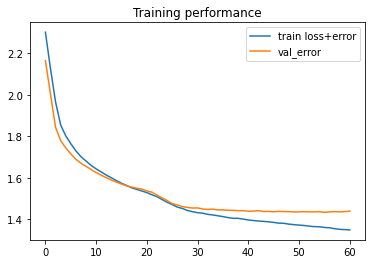

In [17]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

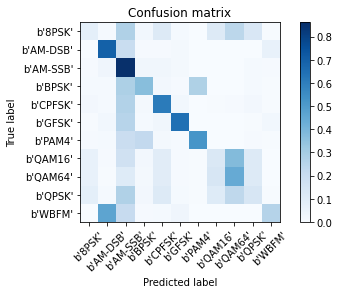

In [19]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [20]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])

#print(snr_label_array)
y_test_snr=snr_array[test_idx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.09375 for SNR b'-20'
Overall Accuracy:  0.1007483117357182 for SNR b'-18'
Overall Accuracy:  0.09826902271907681 for SNR b'-16'
Overall Accuracy:  0.10515727871250914 for SNR b'-14'
Overall Accuracy:  0.12672028596961574 for SNR b'-12'
Overall Accuracy:  0.19385690638219608 for SNR b'-10'
Overall Accuracy:  0.308801775147929 for SNR b'-8'
Overall Accuracy:  0.4735976612461173 for SNR b'-6'
Overall Accuracy:  0.5937612047328792 for SNR b'-4'
Overall Accuracy:  0.6309005083514887 for SNR b'-2'
Overall Accuracy:  0.6054759279676589 for SNR b'0'
Overall Accuracy:  0.6081277213352685 for SNR b'2'
Overall Accuracy:  0.5919487648673376 for SNR b'4'
Overall Accuracy:  0.5934690882406898 for SNR b'6'
Overall Accuracy:  0.5807263574253866 for SNR b'8'
Overall Accuracy:  0.588716853532657 for SNR b'10'
Overall Accuracy:  0.5841980702712544 for SNR b'12'
Overall Accuracy:  0.5954504094631483 for SNR b'14'
Overall Accuracy:  0.5874202370100273 for SNR b'16'
Overall Accuracy:  0

In [24]:
print(acc_array)

[0.09375, 0.1007483117357182, 0.09826902271907681, 0.10515727871250914, 0.12672028596961574, 0.19385690638219608, 0.308801775147929, 0.4735976612461173, 0.5937612047328792, 0.6309005083514887, 0.6054759279676589, 0.6081277213352685, 0.5919487648673376, 0.5934690882406898, 0.5807263574253866, 0.588716853532657, 0.5841980702712544, 0.5954504094631483, 0.5874202370100273, 0.5941654357459379]


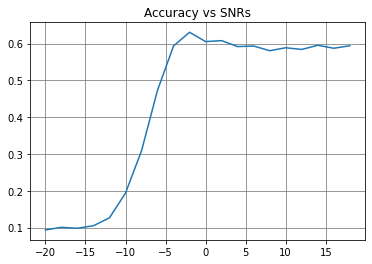

In [22]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), acc_array)

In [27]:
dr_01 = [0.09375, 0.1007483117357182, 0.09826902271907681, 0.10515727871250914, 0.12672028596961574, 0.19385690638219608, 0.308801775147929, 0.4735976612461173, 0.5937612047328792, 0.6309005083514887, 0.6054759279676589, 0.6081277213352685, 0.5919487648673376, 0.5934690882406898, 0.5807263574253866, 0.588716853532657, 0.5841980702712544, 0.5954504094631483, 0.5874202370100273, 0.5941654357459379];
dr_04 = [0.09123563218390805, 0.09709801058587333, 0.09790840245221781, 0.1005852231163131, 0.13315460232350312, 0.22788302372631966, 0.33154585798816566, 0.517266581399598, 0.6149157404087486, 0.5780682643427741, 0.5733186328555678, 0.5767416545718432, 0.5657822506861848, 0.5753072830673271, 0.5586120100683207, 0.5588182950702972, 0.558529036956126, 0.575614194722475, 0.5668185961713765, 0.5795790251107829];
dr_06 = [0.09141522988505747, 0.09928819127578026, 0.09610530111792283, 0.1005852231163131, 0.12707774798927615, 0.21519220158175464, 0.30196005917159763, 0.47030878859857483, 0.57529580494801, 0.5375816993464052, 0.543917677324513, 0.5435413642960812, 0.5313815187557182, 0.5411851036507063, 0.5275080906148867, 0.5278519309485674, 0.5224831603859458, 0.5408553230209281, 0.5358249772105743, 0.5415435745937962];

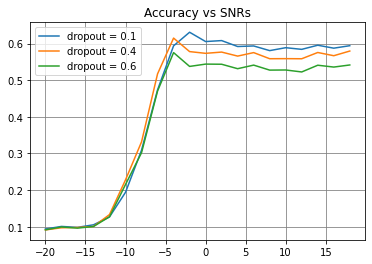

In [31]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), dr_01,label = 'dropout = 0.1')
plt.plot(np.arange(-20,20,2),dr_04,label = 'dropout = 0.4')
plt.plot(np.arange(-20,20,2),dr_06,label = 'dropout = 0.6')
plt.legend(loc="upper left")

In [32]:
bs_256 = [0.09446839080459771, 0.09782807081584231, 0.09790840245221781, 0.10168251645940014, 0.1224307417336908, 0.18962663233400773, 0.2941937869822485, 0.44454595285949206, 0.5751165292219433, 0.635439360929557, 0.621646453509739, 0.6210087082728593, 0.6001829826166514, 0.6017244542285819, 0.5832434376123696, 0.5837337604555971, 0.5803750227562352, 0.5941765241128298, 0.5930720145852324, 0.5932422451994092];
bs_1024 = [0.09464798850574713, 0.0969154955283811, 0.09664623151821132, 0.10076810534016094, 0.12761394101876675, 0.21445650174728711, 0.33653846153846156, 0.49479261830805776, 0.6055934026532808, 0.6125635439360929, 0.5988607129731717, 0.5943396226415094, 0.5769441903019213, 0.5853971748303064, 0.5685005393743258, 0.5680726107848372, 0.5647187329328236, 0.5805277525022748, 0.570464904284412, 0.577917282127031];
bs_5000 = [0.09375, 0.1007483117357182, 0.09826902271907681, 0.10515727871250914, 0.12672028596961574, 0.19385690638219608, 0.308801775147929, 0.4735976612461173, 0.5937612047328792, 0.6309005083514887, 0.6054759279676589, 0.6081277213352685, 0.5919487648673376, 0.5934690882406898, 0.5807263574253866, 0.588716853532657, 0.5841980702712544, 0.5954504094631483, 0.5874202370100273, 0.5941654357459379];

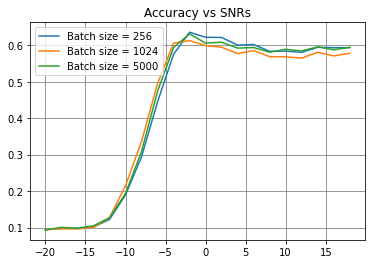

In [33]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), bs_256,label = 'Batch size = 256')
plt.plot(np.arange(-20,20,2),bs_1024,label = 'Batch size = 1024')
plt.plot(np.arange(-20,20,2),bs_5000,label = 'Batch size = 5000')
plt.legend(loc="upper left")